In [166]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, warnings, random, datetime, math

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt

########################### Model
import lightgbm as lgb

warnings.filterwarnings('ignore')

In [167]:
def plot_feature(train, test, feature, log = False):
    df1_0 = train[train['isFraud']==0]
    df1_1 = train[train['isFraud']==1]
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(13,9))
    if log == True:
        sns.kdeplot(np.log(df1_0[feature]), shade = True, label = 'Not Fraud', ax = ax1)
        sns.kdeplot(np.log(df1_1[feature]), shade = True, label = 'Fraud', ax = ax1)
    else:
        sns.kdeplot(df1_0[feature], shade = True, label = 'Not Fraud', ax = ax1)
        sns.kdeplot(df1_1[feature], shade = True, label = 'Fraud', ax = ax1)
        
    
    if log == True:
        sns.kdeplot(np.log(train[feature]), shade = True, label = 'Train', ax = ax2)
        sns.kdeplot(np.log(test[feature]), shade = True, label = 'Test', ax = ax2)
    else:
        sns.kdeplot(train[feature], shade = True, label = 'Train', ax = ax2)
        sns.kdeplot(test[feature], shade = True, label = 'Test', ax = ax2)

In [168]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [169]:
########################### Vars
#################################################################################
SEED = 42
seed_everything(SEED)
TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [170]:
def values_normalization_nominmax(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            dt_df[col] = dt_df[col].astype(float) 

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col +  '_std_score'] = (dt_df[col] - dt_df['temp_mean']) / (dt_df['temp_std'])
            del dt_df['temp_mean'], dt_df['temp_std']
    return dt_df

from scipy.stats import iqr

def values_normalization_med_iqr(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            dt_df[col] = dt_df[col].astype(float) 

            temp_median = dt_df.groupby([period])[col].agg(['median']).reset_index()
            temp_median.index = temp_median[period].values
            temp_median = temp_median['median'].to_dict()

            temp_iqr = dt_df.groupby([period])[col].agg([iqr]).reset_index()
            temp_iqr.index = temp_iqr[period].values
            temp_iqr = temp_iqr['iqr'].to_dict()

            dt_df['temp_median'] = dt_df[period].map(temp_median)
            dt_df['temp_iqr'] = dt_df[period].map(temp_iqr)

            dt_df[new_col +  '_iqr_score'] = (dt_df[col] - dt_df['temp_median'] + 0.01) / (dt_df['temp_iqr'] + 0.01)
            del dt_df['temp_median'], dt_df['temp_iqr']
    return dt_df

In [171]:
def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            dt_df[col] = dt_df[col].astype(float)  

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)
            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col + '_min_max'] = (dt_df[col] - dt_df['temp_min']) / (dt_df['temp_max'] - dt_df['temp_min'])
            dt_df[new_col +  '_std_score'] = (dt_df[col] - dt_df['temp_mean']) / (dt_df['temp_std'])
            del dt_df['temp_min'], dt_df['temp_max'], dt_df['temp_mean'], dt_df['temp_std']
    return dt_df

In [172]:
def frequency_encoding(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
            test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)
    return train_df, test_df

In [173]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None,    # Revised to encode validation series
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

In [174]:
def timeblock_frequency_encoding(train_df, test_df, periods, columns, 
                                 with_proportions=True, only_proportions=False):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period
            train_df[new_col] = train_df[col].astype(str) + '_' + train_df[period].astype(str)
            test_df[new_col]  = test_df[col].astype(str) + '_' + test_df[period].astype(str)

            temp_df = pd.concat([train_df[[new_col]], test_df[[new_col]]])
            fq_encode = temp_df[new_col].value_counts().to_dict()

            train_df[new_col] = train_df[new_col].map(fq_encode)
            test_df[new_col]  = test_df[new_col].map(fq_encode)
            
            if only_proportions:
                train_df[new_col] = train_df[new_col] / train_df[period + '_total']
                test_df[new_col]  = test_df[new_col] / test_df[period + '_total']

            if with_proportions:
                train_df[new_col + '_proportions'] = train_df[new_col] / train_df[period + '_total']
                test_df[new_col + '_proportions']  = test_df[new_col] / test_df[period + '_total']

    return train_df, test_df

In [175]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:                  
                
                new_col_name = col + '_' + main_column + '_' + agg_type
                
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
                
    return train_df, test_df

def uid_aggregation_and_normalization(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            
            new_norm_col_name = col + '_' + main_column + '_std_norm'
            norm_cols = []
            
            for agg_type in aggregations:
                new_col_name = col + '_' + main_column + '_' + agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
                norm_cols.append(new_col_name)
            
            train_df[new_norm_col_name] = (train_df[main_column] - train_df[norm_cols[0]]) / train_df[norm_cols[1]]
            test_df[new_norm_col_name]  = (test_df[main_column] - test_df[norm_cols[0]]) / test_df[norm_cols[1]]          
            
            del train_df[norm_cols[0]], train_df[norm_cols[1]]
            del test_df[norm_cols[0]], test_df[norm_cols[1]]
                                              
    return train_df, test_df

In [176]:
def check_cor_and_remove(train_df, test_df, i_cols, new_columns, remove=False):
    # Check correllation
    print('Correlations','#'*10)
    for col in new_columns:
        cor_cof = np.corrcoef(train_df[TARGET], train_df[col].fillna(0))[0][1]
        print(col, cor_cof)

    if remove:
        print('#'*10)
        print('Best options:')
        best_fe_columns = []
        for main_col in i_cols:
            best_option = ''
            best_cof = 0
            for col in new_columns:
                if main_col in col:
                    cor_cof = np.corrcoef(train_df[TARGET], train_df[col].fillna(0))[0][1]
                    cor_cof = (cor_cof**2)**0.5
                    if cor_cof > best_cof:
                        best_cof = cor_cof
                        best_option = col

            print(main_col, best_option, best_cof)            
            best_fe_columns.append(best_option)

        for col in new_columns:
            if col not in best_fe_columns:
                del train_df[col], test_df[col]

    return train_df, test_df

In [177]:
def timehist1_2(col, product):
    #N = 8000 if col in ['TransactionAmt'] else 9999999999999999 # clip trans amount for better view
    train_df[(train_df['isFraud'] == 0) & (train_df['ProductCD'] == product)].set_index('TransactionDT')[col].plot(style='.', title='Hist ' + col, figsize=(15, 3))
    train_df[(train_df['isFraud'] == 1) & (train_df['ProductCD'] == product)].set_index('TransactionDT')[col].plot(style='.', title='Hist ' + col, figsize=(15, 3))
    test_df[test_df['ProductCD'] == product].set_index('TransactionDT')[col].plot(style='.', title=col + ' values over time (blue=no-fraud, orange=fraud, green=test)', figsize=(15, 3))
    plt.show()

In [178]:
def fill_pairs(train, test, pairs):
    for pair in pairs:

        unique_train = []
        unique_test = []

        print(f'Pair: {pair}')
        print(f'In train{[pair[1]]} there are {train[pair[1]].isna().sum()} NaNs' )
        print(f'In test{[pair[1]]} there are {test[pair[1]].isna().sum()} NaNs' )

        for value in train[pair[0]].unique():
            unique_train.append(train[pair[1]][train[pair[0]] == value].value_counts().shape[0])

        for value in test[pair[0]].unique():
            unique_test.append(test[pair[1]][test[pair[0]] == value].value_counts().shape[0])

        pair_values_train = pd.Series(data=unique_train, index=train[pair[0]].unique())
        pair_values_test = pd.Series(data=unique_test, index=test[pair[0]].unique())
        
        print('Filling train...')

        for value in pair_values_train[pair_values_train == 1].index:
            train.loc[train[pair[0]] == value, pair[1]] = train.loc[train[pair[0]] == value, pair[1]].value_counts().index[0]

        print('Filling test...')

        for value in pair_values_test[pair_values_test == 1].index:
            test.loc[test[pair[0]] == value, pair[1]] = test.loc[test[pair[0]] == value, pair[1]].value_counts().index[0]

        print(f'In train{[pair[1]]} there are {train[pair[1]].isna().sum()} NaNs' )
        print(f'In test{[pair[1]]} there are {test[pair[1]].isna().sum()} NaNs' )
        
    return train, test

In [179]:
from sklearn.decomposition import PCA 

def pca_made_cols(train, test, pair):
    group = ['V' + str(num) for num in range(pair[0], pair[1] + 1)]
    pca_df = pd.concat([train_df, test_df])[group].dropna()
    pca = PCA().fit(pca_df)
    
    sums = np.cumsum(pca.explained_variance_ratio_)
    num = len([x for x in sums if x <= 0.98])
    
    if len(group) > num:
        sklearn_pca = PCA(n_components = num + 1)
        sklearn_pca.fit(pca_df[group])
        print(pair, num + 1)
        
        #train
        group_new = sklearn_pca.transform(train[group].dropna())
        group_new = pd.DataFrame(group_new)
        name_dict = {}

        for i in range(group_new.shape[1]):
            name_dict[i] = 'V_' + str(pair[0]) + '_' + str(pair[1]) + '_' + str(i)

        new_ind_group = group_new.set_index(pd.Index(train[group].dropna().index)).rename(name_dict, axis=1)
        train.drop(group, axis=1, inplace=True)
        train = pd.concat([train, new_ind_group], join='outer', axis=1)
        
        # test
        group_new = sklearn_pca.transform(test[group].dropna())
        group_new = pd.DataFrame(group_new)
        
        new_ind_group = group_new.set_index(pd.Index(test[group].dropna().index)).rename(name_dict, axis=1)
        test.drop(group, axis=1, inplace=True)
        test = pd.concat([test, new_ind_group], join='outer', axis=1)

    return train, test

pairs = [(1,11), (12, 34), (35, 52), (53, 74), (75, 94), (95, 137), (138, 166), (167, 216), (217, 278), (279, 321), (322, 339)]

#for pair in pairs:
#    train_df, test_df = pca_made_cols(train_df, test_df, pair)

----

In [180]:
########################### DATA LOAD
#################################################################################
print('Load Data')
train_df = pd.read_pickle('preprocessed_data_2/train_transaction.pkl')
test_df = pd.read_pickle('preprocessed_data_2/test_transaction.pkl')
train_identity = pd.read_pickle('preprocessed_data_2/train_identity.pkl')
test_identity = pd.read_pickle('preprocessed_data_2/test_identity.pkl')

base_columns = list(train_df.columns) + list(train_identity.columns)

print('Shape control:', train_df.shape, test_df.shape)

Load Data
Shape control: (590540, 123) (506691, 123)


In [181]:
remove_features = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    TARGET,
    ]

base_columns = [col for col in list(train_df) if col not in remove_features]

In [182]:
########################### Device info and identity
for df in [train_identity, test_identity]:
    ########################### Device info
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Device info 2
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    
########################### Merge Identity columns
temp_df = train_df[['TransactionID']]
temp_df = temp_df.merge(train_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
train_df = pd.concat([train_df,temp_df], axis=1)
    
temp_df = test_df[['TransactionID']]
temp_df = temp_df.merge(test_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
test_df = pd.concat([test_df,temp_df], axis=1)

In [183]:
########################### TransactionDT
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

# Let's add temporary "time variables" for aggregations
# and add normal "time variables"
for df in [train_df, test_df]:
    
    # Temporary variables for aggregation
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = ((df['DT'].dt.year-2017)*12 + df['DT'].dt.month).astype(np.int8)
    df['DT_W'] = ((df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear).astype(np.int8)
    df['DT_D'] = ((df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear).astype(np.int16)
    
    df['DT_hour'] = (df['DT'].dt.hour).astype(np.int8)
    df['DT_day_week'] = (df['DT'].dt.dayofweek).astype(np.int8)
    df['DT_day_month'] = (df['DT'].dt.day).astype(np.int8)

# Remove temporary features from final list
remove_features += ['DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month']
    
# Total transactions per timeblock
for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train_df[col + '_total'] = train_df[col].map(fq_encode)
    test_df[col + '_total'] = test_df[col].map(fq_encode)
    
    # We can't use it as solo feature
    remove_features.append(col + '_total')

In [184]:
########################### Card columns "outliers"
for col in ['card1']: 
    valid_card = pd.concat([train_df[[col]], test_df[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card_std = valid_card.values.std()

    invalid_cards = valid_card[valid_card<=2]
    print('Rare cards', len(invalid_cards))

    valid_card = valid_card[valid_card>2]
    valid_card = list(valid_card.index)

    print('No intersection in Train', len(train_df[~train_df[col].isin(test_df[col])]))
    print('Intersection in Train', len(train_df[train_df[col].isin(test_df[col])]))
    
    train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)
    print('#'*20)

for col in ['card2','card3','card4','card5','card6',]: 
    print('No intersection in Train', col, len(train_df[~train_df[col].isin(test_df[col])]))
    print('Intersection in Train', col, len(train_df[train_df[col].isin(test_df[col])]))
    
    train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)
    print('#'*20)

Rare cards 5993
No intersection in Train 10396
Intersection in Train 580144
####################
No intersection in Train card2 5012
Intersection in Train card2 585528
####################
No intersection in Train card3 47
Intersection in Train card3 590493
####################
No intersection in Train card4 0
Intersection in Train card4 590540
####################
No intersection in Train card5 7279
Intersection in Train card5 583261
####################
No intersection in Train card6 30
Intersection in Train card6 590510
####################


In [185]:
groups = pd.read_csv('groups (3).csv', index_col='TransactionID')
user_id = pd.read_csv('UserID (1).csv', index_col='TransactionID')

# train_df = train_df.merge(groups, on='TransactionID', how='left')
# test_df = test_df.merge(groups, on='TransactionID', how='left')


train_df = train_df.merge(user_id, on='TransactionID', how='left')
test_df = test_df.merge(user_id, on='TransactionID', how='left')

In [186]:
########################### Client Virtual ID
# Let's add some kind of client uID based on cardID and addr columns
# The value will be very specific for each client so we need to remove it
# from final features. But we can use it for aggregations.

train_df['uid_DT'] = (train_df['D1'] - train_df['DT_D']).astype(str) + '__' + train_df['card1'].astype(str) + '__' + train_df['card2'].astype(str) + '__' + train_df['card5'].astype(str)
test_df['uid_DT'] = (test_df['D1'] - test_df['DT_D']).astype(str) + '__' + test_df['card1'].astype(str) + '__' + test_df['card2'].astype(str) + '__' + test_df['card5'].astype(str)

train_df['uid5'] = train_df['uid_DT'].astype(str)+'_'+train_df['TransactionAmt'].astype(str)
test_df['uid5'] = test_df['uid_DT'].astype(str)+'_'+test_df['TransactionAmt'].astype(str)

remove_features += ['uid5', 'D1']

# Add values remove list
new_columns = ['uid_DT', 'UserID_proxy']
remove_features += new_columns

#Freq
print('#'*10)
print('Most common uIds:')
for col in new_columns:
    print('#'*10, col)
    print(train_df[col].value_counts()[:10])

# Do Global frequency encoding 
i_cols = ['card1','card2','card3','card5'] + new_columns
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=False)

##########
Most common uIds:
########## uid_DT
-463.0__15775.0__481.0__102.0    1414
-249.0__9500.0__321.0__226.0      482
-426.0__7919.0__194.0__166.0      439
-458.0__7919.0__194.0__166.0      285
-368.0__7919.0__194.0__nan        242
157.0__12616.0__490.0__nan        242
-274.0__8900.0__385.0__226.0      232
-397.0__7919.0__194.0__nan        226
-175.0__8528.0__215.0__226.0      215
-335.0__7919.0__194.0__nan        212
Name: uid_DT, dtype: int64
########## UserID_proxy
Sgroup33      1460
group238       577
group73        275
Hgroup143      207
group72        193
Hgroup1120     144
group495       143
group404       134
group147       129
group789       125
Name: UserID_proxy, dtype: int64


In [187]:
# Clip Values
train_df['TransactionAmt'] = train_df['TransactionAmt'].clip(0,5000)
test_df['TransactionAmt']  = test_df['TransactionAmt'].clip(0,5000)

# Check if the Transaction Amount is common or not (we can use freq encoding here)
# In our dialog with a model we are telling to trust or not to these values   
train_df['TransactionAmt_check'] = np.where(train_df['TransactionAmt'].isin(test_df['TransactionAmt']), 1, 0)
test_df['TransactionAmt_check']  = np.where(test_df['TransactionAmt'].isin(train_df['TransactionAmt']), 1, 0)

# For our model current TransactionAmt is a noise
# https://www.kaggle.com/kyakovlev/ieee-check-noise
# (even if features importances are telling contrariwise)
# There are many unique values and model doesn't generalize well
# Lets do some aggregations
i_cols = ['TransactionAmt']
uids = ['card1','card2','card3','card5', 'uid_DT', 'UserID_proxy']
aggregations = ['mean']

# uIDs aggregations
train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)
 
# TransactionAmt Normalization
periods = ['DT_D','DT_W','DT_M']
for df in [train_df, test_df]:
    df = values_normalization(df, periods, i_cols)

# Product type
train_df['product_type'] = train_df['ProductCD'].astype(str)+'_'+train_df['TransactionAmt'].astype(str)
test_df['product_type'] = test_df['ProductCD'].astype(str)+'_'+test_df['TransactionAmt'].astype(str)

i_cols = ['product_type']
periods = ['DT_D','DT_W','DT_M']
train_df, test_df = timeblock_frequency_encoding(train_df, test_df, periods, i_cols, 
                                                 with_proportions=False, only_proportions=True)
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=True)

In [188]:
i_cols = ['D'+str(i) for i in range(2,16)]
uids = ['uid_DT', 'UserID_proxy']
aggregations = ['mean', 'std']

####### uIDs aggregations
train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

####### Cleaning Neagtive values and columns transformations
for df in [train_df, test_df]:

    for col in i_cols:
        df[col] = df[col].clip(0) 
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

# ####### Values 
i_cols = ['D'+str(i) for i in range(2,16)]
i_cols.remove('D2')
i_cols.remove('D9')

for col in i_cols:
    train_df[col] = train_df[col] - train_df['DT_D']
    test_df[col] = test_df[col] - test_df['DT_D']

for col in ['D2']:
    for df in [train_df, test_df]:
        df[col + '_scaled'] = df[col] / df[col].max()

#drop d1, d2

In [189]:
########################### C Columns
i_cols = ['C'+str(i) for i in range(1,15)]
uids = ['uid_DT', 'UserID_proxy']
aggregations = ['mean', 'std']

####### uIDs aggregations
train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

####### Global Self frequency encoding
# self_encoding=False because 
# I want to keep original values
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=False)

####### Clip max values
for df in [train_df, test_df]:
    for col in i_cols:
        max_value = train_df[train_df['DT_M']==train_df['DT_M'].max()][col].max()
        df[col] = df[col].clip(None,max_value) 

In [190]:
i_cols = ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1',
                'M2__M3', 'D8__D9', 'id_19__id_20']

# Some arbitrary features interaction
for feature in i_cols:

    f1, f2 = feature.split('__')
    train_df[feature] = train_df[f1].astype(str) + '_' + train_df[f2].astype(str)
    test_df[feature] = test_df[f1].astype(str) + '_' + test_df[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train_df[feature].astype(str).values) + list(test_df[feature].astype(str).values))
    train_df[feature] = le.transform(list(train_df[feature].astype(str).values))
    test_df[feature] = le.transform(list(test_df[feature].astype(str).values))
    
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=True)

In [191]:
i_cols = [
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31','id_31_device',
          'id_33',
         ]

####### Global Self frequency encoding
# self_encoding=True because 
# we don't need original values anymore
train_df, test_df = frequency_encoding(train_df, test_df, i_cols, self_encoding=True)

In [192]:
train_df, test_df = uid_aggregation(train_df, test_df, ['TransactionDT'], ['uid5'],['count', 'std'])

In [193]:
uids = ['uid_DT']

train_test = pd.concat([train_df[i_cols + ['TransactionAmt', 'C5']], test_df[i_cols + ['TransactionAmt', 'C5']]])

for col in i_cols:
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    
    col_count1 = train_test[train_test['C5'] == 0].groupby(col)['C5'].count()
    col_count2 = train_test[train_test['C5'] != 0].groupby(col)['C5'].count()
    
    train_df[col+'_C5count'] = (train_df[col].map(col_count2) + 0.01) / (train_df[col].map(col_count1) + 0.01)
    test_df[col+'_C5count'] = (test_df[col].map(col_count2) + 0.01) / (test_df[col].map(col_count1) + 0.01)

In [194]:
i_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'DeviceInfo', 'id_31', 'id_19__id_20', 'addr1', 'addr2']
uids = ['UserID_proxy']
aggregations = ['nunique']

####### uIDs aggregations
train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

In [195]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,UserID_proxy_card2_nunique,UserID_proxy_card3_nunique,UserID_proxy_card4_nunique,UserID_proxy_card5_nunique,UserID_proxy_card6_nunique,UserID_proxy_DeviceInfo_nunique,UserID_proxy_id_31_nunique,UserID_proxy_id_19__id_20_nunique,UserID_proxy_addr1_nunique,UserID_proxy_addr2_nunique
0,2987000,0,86400,68.5,800657,13926.0,327.0,150.0,9524.0,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,800657,2755.0,404.0,150.0,347386.0,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,800657,4663.0,490.0,150.0,719649.0,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,800657,18132.0,567.0,150.0,347386.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,62397,4497.0,514.0,150.0,347386.0,102.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [196]:
# i_cols = ['D'+str(i) for i in range(1,16)]

# train_df.drop(i_cols, axis=1, inplace=True)
# test_df.drop(i_cols, axis=1, inplace=True)

In [197]:
########################### Encode Str columns
# For all such columns (probably not)
# we already did frequency encoding (numeric feature)
# so we will use astype('category') here
for col in list(train_df):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])

P_emaildomain
R_emaildomain
DeviceType
UserID_proxy
uid_DT
uid5


In [198]:
useful_features = ['TransactionAmt', 'ProductCD', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1','D2', 'D3', 'D5', 'D6', 'D7','D8', 'D9', 'D10', 'D12', 'D13', 'D14', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V_1_11_0', 'V_1_11_1', 'V_1_11_2', 'V_1_11_3', 'V_1_11_4', 'V_1_11_5', 
                   'V_1_11_6', 'V_12_34_0', 'V_12_34_1', 'V_12_34_2', 'V_12_34_3', 'V_12_34_4', 'V_12_34_5', 'V_12_34_6', 
                   'V_12_34_7', 'V_12_34_8', 'V_12_34_9', 'V_12_34_10', 'V_12_34_11', 'V_35_52_0', 'V_35_52_1', 'V_35_52_2', 
                   'V_35_52_3', 'V_35_52_4', 'V_35_52_5', 'V_35_52_6', 'V_35_52_7', 'V_35_52_8', 'V_53_74_0', 'V_53_74_1', 
                   'V_53_74_2', 'V_53_74_3', 'V_53_74_4', 'V_53_74_5', 'V_53_74_6', 'V_53_74_7', 'V_53_74_8', 'V_53_74_9', 
                   'V_53_74_10', 'V_53_74_11', 'V_75_94_0', 'V_75_94_1', 'V_75_94_2', 'V_75_94_3', 'V_75_94_4', 'V_75_94_5', 
                   'V_75_94_6', 'V_75_94_7', 'V_75_94_8', 'V_75_94_9', 'V_75_94_10', 'V_95_137_0', 'V_95_137_1', 'V_95_137_2', 
                   'V_138_166_0', 'V_167_216_0', 'V_167_216_1', 'V_167_216_2', 'V_217_278_0', 'V_217_278_1', 'V_217_278_2', 
                   'V_322_339_0', 'V_322_339_1', 'V_322_339_2', 
                   'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_32',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
#, 'D15, 'id_31','V_279_321_0', 'V_279_321_1', 'V_279_321_2', 'V_279_321_3',


In [199]:
# tutti_feature_train = pd.read_csv('myfeature2.csv', index_col='TransactionID').drop(['Unnamed: 0'], axis=1)
# train_df = train_df.merge(tutti_feature_train, on=['TransactionID'], how='left')

# tutti_feature_test = pd.read_csv('myfeatureS_testsample.csv', index_col='TransactionID').rename({'myfeaturetrain' : 'myfeature'}, axis=1)
# test_df = test_df.merge(tutti_feature_test, on=['TransactionID'], how='left')

In [200]:
features_columns = [col for col in list(train_df) if col not in remove_features]

bad_features = [col for col in base_columns if col not in useful_features]

bad_features = list(set(bad_features) - (set(bad_features) - set(train_df[features_columns].columns)))

In [201]:
X = train_df.sort_values('TransactionDT')[features_columns].drop(bad_features, axis=1)
y = train_df.sort_values('TransactionDT')['isFraud']
dt_m = train_df.sort_values('TransactionDT')['DT_M']

X_test = test_df[features_columns].drop(bad_features, axis=1)

In [202]:
# train = train_df.sort_values('TransactionDT')[['TransactionID', 'isFraud', 'DT_M'] + features_columns].drop(bad_features, axis=1)
# test = test_df.sort_values('TransactionDT')[['TransactionID'] + features_columns].drop(bad_features, axis=1)

# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

# train.to_csv('train.csv', index=False)
# test.to_csv('test.csv', index=False)

In [203]:
X.shape, X_test.shape

((590540, 343), (506691, 343))

In [204]:
X = reduce_mem_usage(X)
X_test = reduce_mem_usage(X_test)

Mem. usage decreased to 619.50 Mb (52.7% reduction)
Mem. usage decreased to 551.54 Mb (51.8% reduction)


In [205]:
X.to_pickle('X.pkl')
y.to_pickle('y.pkl')
X_test.to_pickle('X_test.pkl')
dt_m.to_pickle('dt_m.pkl')

In [206]:
# del train_df, test_df, X_test, train_identity, test_identity, X, y
# gc.collect()

In [207]:
import neptune

neptune.init(api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5tbCIsImFwaV9rZXkiOiI2N2FkYWE1Ni1lMDY3LTQxMmItYjc1OC1hMDNlNTRmYjU3ZmYifQ==', 
             project_qualified_name='grazder/ieee-fraud')

Project(grazder/ieee-fraud)

In [208]:
# target_enc_cols = ['ProductCD','M4']

X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')
X_test = pd.read_pickle('X_test.pkl')
dt_m = pd.read_pickle('dt_m.pkl')

In [214]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          #'learning_rate': 0.006883242363721497,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
          'num_threads': 8
         }

# params = {
#                 'objective':'binary',
#                 'boosting_type':'gbdt',
#                 'metric':'auc',
#                 'n_jobs':-1,
#                 'learning_rate':0.01,
#                 'num_leaves': 2**8,
#                 'max_depth':-1,
#                 'tree_learner':'serial',
#                 'colsample_bytree': 0.7,
#                 'subsample_freq':1,
#                 'subsample':0.7,
#                 'max_bin':255,
#                 'verbose':-1,
#                 'seed': 13,
#                 'num_threads': 8,
#                 'n_estimators': 1000,
#             } 

In [215]:
%%time

NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y, groups=dt_m)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = list(columns)

clfs = []
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
#     for f in target_enc_cols:
#         X_train[f + '_avg'], X_valid[f + '_avg'], X_test[f + '_avg'] = target_encode(
#                                                     trn_series=X_train[f],
#                                                     val_series=X_valid[f],
#                                                     tst_series=X_test[f],
#                                                     target=y_train,
#                                                     min_samples_leaf=100,
#                                                     smoothing=10,
#                                                     noise_level=0
#                                                     )
    
    # Run model for this fold
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 1000, valid_sets = [dtrain, dvalid], verbose_eval=500)
    clfs.append(clf)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

[500]	training's auc: 0.999997	valid_1's auc: 0.93187
[1000]	training's auc: 1	valid_1's auc: 0.932714
Fold 1 | AUC: 0.9327192350265184
[500]	training's auc: 0.999997	valid_1's auc: 0.960982
[1000]	training's auc: 1	valid_1's auc: 0.960807
Fold 2 | AUC: 0.9608185328554987
[500]	training's auc: 0.999997	valid_1's auc: 0.958394
[1000]	training's auc: 1	valid_1's auc: 0.958563
Fold 3 | AUC: 0.9585575116216076
[500]	training's auc: 0.999995	valid_1's auc: 0.951425
[1000]	training's auc: 1	valid_1's auc: 0.950881
Fold 4 | AUC: 0.9508752244359107
[500]	training's auc: 0.999999	valid_1's auc: 0.967027
[1000]	training's auc: 1	valid_1's auc: 0.967125
Fold 5 | AUC: 0.9671220677232563

Mean AUC = 0.9540185143325584
Out of folds AUC = 0.955792359350268
CPU times: user 3h 50min 35s, sys: 52.2 s, total: 3h 51min 27s
Wall time: 30min 41s


* card1 - 0.9387
* card1_card2 - 0.93908
* card1_card3 - 0.93859
* card1_card4 - 0.93864 
* card1_card5 - 0.93921
* card1_card6 - 0.93865
* card1_card2_card5 - 0.93928
* no card1 - 0.93979
* michals - 0.93969
* userID - 0.9404

In [216]:
neptune.create_experiment(params=params)
neptune.send_metric('local cv', score)
neptune.send_metric('oof score', roc_auc_score(y, y_oof))
neptune.stop()

https://ui.neptune.ml/grazder/ieee-fraud/e/FRAUD-229


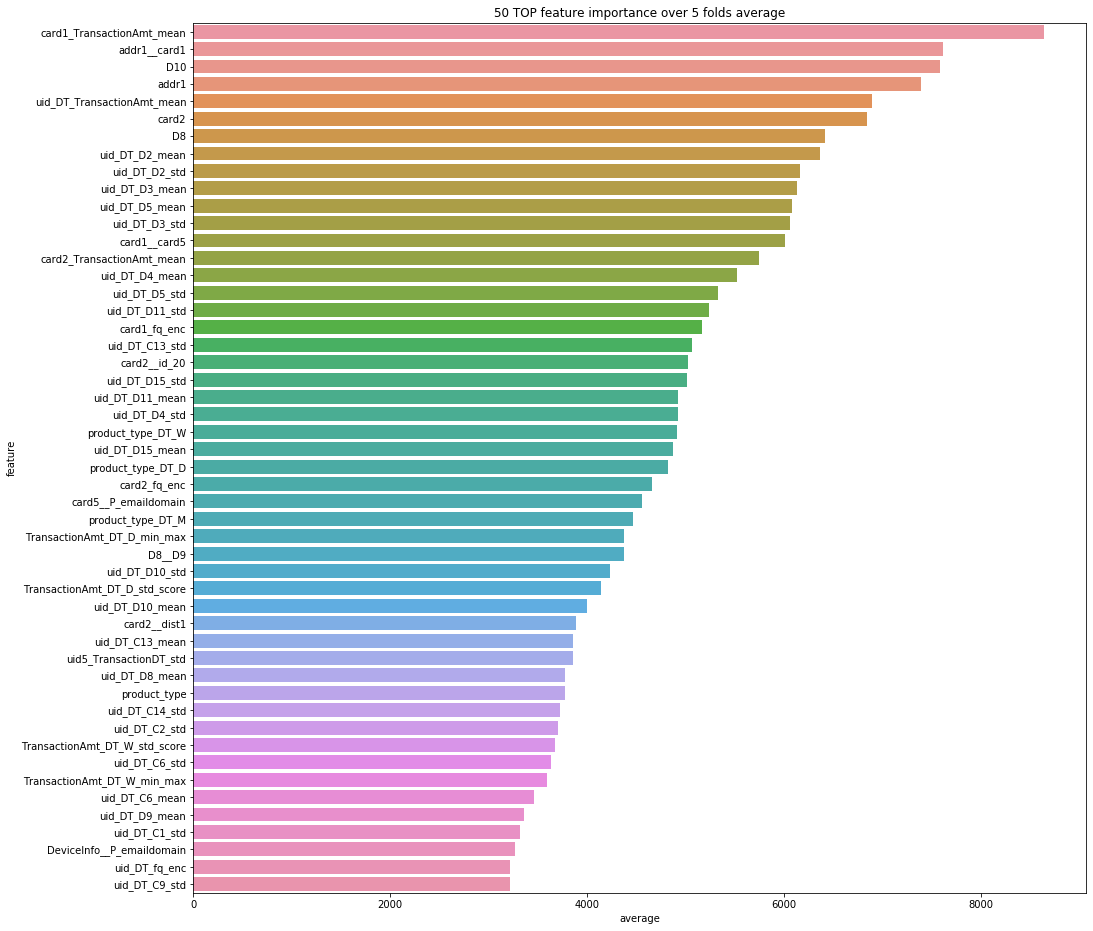

In [217]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [219]:
import os

name = 'user_id' + '_' + str(int(score * 10000))
path = "submit_final/" + name

os.mkdir(path)

sample_submission = pd.read_csv('../sample_submission.csv', index_col='TransactionID').reset_index()
sample_submission["isFraud"] = y_preds
sample_submission.to_csv('submit_final/' + name + '/test_' + name +'.csv', index=False)

train_oof = pd.DataFrame()
train_oof['TransactionID'] = train_df.sort_values('TransactionDT')['TransactionID']
train_oof['isFraud'] = y_oof
train_oof.to_csv('submit_final/' + name + '/train_' + name + '.csv', index=False)